# Preliminary EDA

In [6]:
# Suppress native-hadoop warning
!sed -i '$a\# Add the line for suppressing the NativeCodeLoader warning \nlog4j.logger.org.apache.hadoop.util.NativeCodeLoader=ERROR,console' /$HADOOP_HOME/etc/hadoop/log4j.properties
# Auto reload modules
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
import sys
sys.path.append('/home/work')
BASE_DIR = '/home/work'
DATA_DIR = BASE_DIR + '/data'

DATASET = '/processed/user_song_balanced'
TRAIN_DIR = DATA_DIR + DATASET + '/train'
TEST_DIR = DATA_DIR + DATASET + '/test'

In [8]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import split, col, count, desc, min, max, log, abs, mean, stddev, row_number, rand
from pyspark.sql.window import Window
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from data.utils.data_loader import load_file_from_hdfs

from preparation.utils.clean_data import cleaned_df

In [9]:
conf = pyspark.SparkConf()
settings = conf.getAll()

# Set Spark Settings
conf = pyspark.SparkConf().setAll([
('spark.master', 'local[4]'),
('spark.app.name', 'MusicRecommender'),
('spark.driver.memory','14g')])
spark = SparkSession.builder.config(conf=conf).getOrCreate()

# Print the Spark Session settings
settings = spark.sparkContext.getConf().getAll()
for s in settings:
    print(s)

('spark.app.startTime', '1717567058371')
('spark.app.id', 'local-1717567059072')
('spark.master', 'local[4]')
('spark.sql.warehouse.dir', 'file:/home/spark-warehouse')
('spark.executor.id', 'driver')
('spark.app.submitTime', '1717567058284')
('spark.driver.extraJavaOptions', '-Djava.net.preferIPv6Addresses=false -XX:+IgnoreUnrecognizedVMOptions --add-opens=java.base/java.lang=ALL-UNNAMED --add-opens=java.base/java.lang.invoke=ALL-UNNAMED --add-opens=java.base/java.lang.reflect=ALL-UNNAMED --add-opens=java.base/java.io=ALL-UNNAMED --add-opens=java.base/java.net=ALL-UNNAMED --add-opens=java.base/java.nio=ALL-UNNAMED --add-opens=java.base/java.util=ALL-UNNAMED --add-opens=java.base/java.util.concurrent=ALL-UNNAMED --add-opens=java.base/java.util.concurrent.atomic=ALL-UNNAMED --add-opens=java.base/sun.nio.ch=ALL-UNNAMED --add-opens=java.base/sun.nio.cs=ALL-UNNAMED --add-opens=java.base/sun.security.action=ALL-UNNAMED --add-opens=java.base/sun.util.calendar=ALL-UNNAMED --add-opens=java.secu

Load choosen partition of song ratings, song attributes, and genre hierarchy.

In [10]:
song_ratings_train_file_path = "/raw/train/train_2.txt"
song_ratings_train = load_file_from_hdfs(song_ratings_train_file_path)

song_ratings_test_file_path = "/raw/test/test_2.txt"
song_ratings_test = load_file_from_hdfs(song_ratings_test_file_path)

song_ratings = song_ratings_train.union(song_ratings_test) # combine the train and test partition

song_attributes_file_path = "song-attributes.txt"
song_attributes = load_file_from_hdfs(song_attributes_file_path)

genre_hierarchy_file_path = "genre-hierarchy.txt"
genre_hierarchy = load_file_from_hdfs(genre_hierarchy_file_path)

Call cleaned_df function to get cleaned df from EDA

In [11]:
df = cleaned_df(song_ratings, song_attributes, genre_hierarchy)

root
 |-- user_id: integer (nullable = true)
 |-- song_id: integer (nullable = true)
 |-- rating: integer (nullable = true)
 |-- album_id: integer (nullable = true)
 |-- artist_id: integer (nullable = true)
 |-- genre_id: integer (nullable = true)
 |-- genre_name: string (nullable = true)



+-------+------------------+-----------------+------------------+------------------+------------------+------------------+-----------------+
|summary|           user_id|          song_id|            rating|          album_id|         artist_id|          genre_id|       genre_name|
+-------+------------------+-----------------+------------------+------------------+------------------+------------------+-----------------+
|  count|          78909821|         78909821|          78909821|          78909821|          78909821|          78909821|         78909821|
|   mean|499746.46840439545|68274.02707812504|3.1528440674070213|10361.592222392697|4776.0641216636395|16.666298850177345|             NULL|
| stddev| 57936.75037674207|39459.18779033151|1.6030326088607252| 5906.090895444379| 2680.786813237493| 42.91624825455018|             NULL|
|    min|            400000|                0|                 1|                 0|                 0|                 0|Adult Alternative|
|    max|    

Null Columns in cleaned df: {'user_id': 0, 'song_id': 0, 'rating': 0, 'album_id': 0, 'artist_id': 0, 'genre_id': 0, 'genre_name': 0}


In [12]:
df.count()

78909821

Get users' rating count to ensure balanced distribution of ratings per user.

In [13]:
user_ratings_count = df.groupBy("user_id").count()
user_ratings_count = user_ratings_count.withColumnRenamed("count", "ratings_count")
user_ratings_count.show()

+-------+-------------+
|user_id|ratings_count|
+-------+-------------+
| 400003|          266|
| 400129|           60|
| 400152|          108|
| 400301|          375|
| 400440|           36|
| 400612|           67|
| 400735|          312|
| 400797|          161|
| 400833|           69|
| 400982|          687|
| 401161|           38|
| 401778|           43|
| 401880|          403|
| 401901|          678|
| 402253|          161|
| 402643|         2183|
| 402896|          140|
| 403340|         7576|
| 403389|         1021|
| 403422|           33|
+-------+-------------+
only showing top 20 rows



Min and max values of users are quite different. There must be some outliers.

In [14]:
min_max_values = user_ratings_count.select(min("ratings_count").alias("min_value"), max("ratings_count").alias("max_value")).first()

min_value = min_max_values["min_value"]
max_value = min_max_values["max_value"]

print("Minimum value:", min_value)
print("Maximum value:", max_value)

Minimum value: 30
Maximum value: 131533


As expected, distribution is extremely skewed, as shown in the histogram below. The are an extremely small amount of users who rated more than 10000 ratings. The distribution needs to be adjusted to account for outliers.

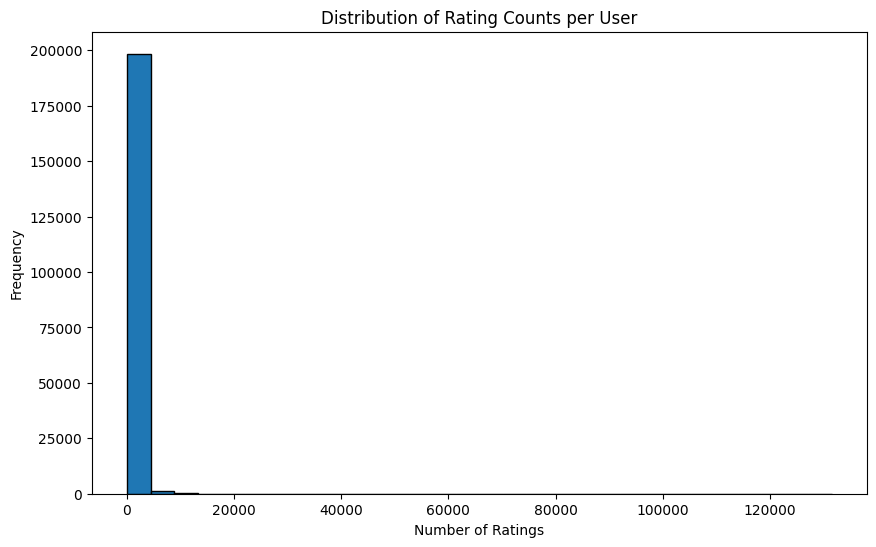

Total number of users: 200000


In [15]:
data= user_ratings_count.toPandas()

plt.figure(figsize=(10, 6))
plt.hist(data['ratings_count'], bins=30, edgecolor='black')
plt.title('Distribution of Rating Counts per User')
plt.xlabel('Number of Ratings')
plt.ylabel('Frequency')
plt.show()

total_users = user_ratings_count.count()
print("Total number of users:", total_users)

Use log and z-score in attempts to find outliers.

In [16]:
user_ratings_count[user_ratings_count['ratings_count'] == 0].count() # no zero
user_ratings_count = user_ratings_count.withColumn('log_ratings_count', log(user_ratings_count['ratings_count']))  

In [17]:
mean_log = user_ratings_count.select(mean(col("log_ratings_count"))).collect()[0][0]
stddev_log = user_ratings_count.select(stddev(col("log_ratings_count"))).collect()[0][0]

user_ratings_count = user_ratings_count.withColumn("z_score", (col("log_ratings_count") - mean_log) / stddev_log)
user_ratings_count = user_ratings_count.withColumn("is_outlier", abs(col("z_score")) > 3) # threshold 3

In [18]:
user_ratings_count_cleaned = user_ratings_count.filter(col("is_outlier") == False)
print("User ratings dataFrame without outliers (log/z-score):", user_ratings_count_cleaned.count())

User ratings dataFrame without outliers (log/z-score): 199351


Still extremely skewed with large range of ratings count. Removing outliers will also disable recommendations for those users.

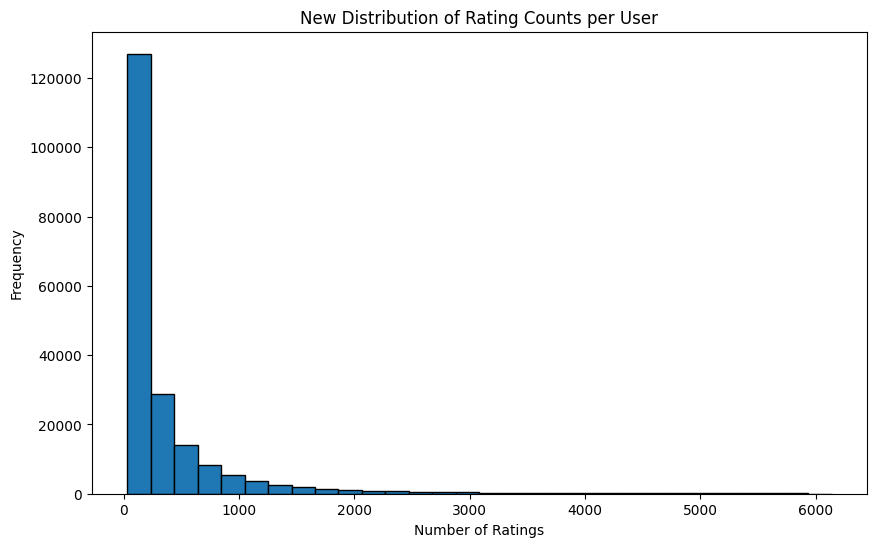

In [19]:
user_ratings_count_cleaned_data = user_ratings_count_cleaned.toPandas()

plt.figure(figsize=(10, 6))
plt.hist(user_ratings_count_cleaned_data['ratings_count'], bins=30, edgecolor='black')
plt.title('New Distribution of Rating Counts per User')
plt.xlabel('Number of Ratings')
plt.ylabel('Frequency')
plt.show()

In [20]:
user_ratings_count_cleaned_df = df.join(user_ratings_count_cleaned.select("user_id"), on="user_id", how="inner")
user_ratings_count_cleaned_df.count() # number of ratings left

72806352

Use IQR, lower bound, upper bound to downsampled outliers instead

In [23]:
quantiles = user_ratings_count.approxQuantile("ratings_count", [0.25, 0.75], 0.05)
Q1 = quantiles[0]
Q3 = quantiles[1]
IQR = Q3 - Q1

# lower_bound = Q1 - (1.5 * IQR)
upper_bound = Q3 + (1.5 * IQR)
print("Upper bound:", upper_bound)

filtered_below_upper_bound = user_ratings_count.filter(col("ratings_count") < upper_bound)
ratings_below_upper_bound = df.join(filtered_below_upper_bound, on="user_id", how="inner")
users_above_upper_bound = user_ratings_count.filter(col("ratings_count") > upper_bound)
ratings_above_upper_bound = df.join(users_above_upper_bound, on="user_id", how="inner")

# Shuffle user ratings above the upper bound
ratings_with_random = ratings_above_upper_bound.withColumn("rand", rand())
window_spec = Window.partitionBy("user_id").orderBy("rand")

# Sample ratings above the upper bound to match the number of ratings at the upper bound
ratings_with_row_number = ratings_with_random.withColumn("row_number", row_number().over(window_spec))
resampled_ratings = ratings_with_row_number.filter(col("row_number") <= upper_bound).drop("rand", "row_number")

filtered_df = ratings_below_upper_bound.union(resampled_ratings)

print("Data count after downsampling outliers:", filtered_df.count())

Upper bound: 724.0


Data count after downsampling outliers: 50296259


Although it is still skewed, the distribution of rating counts per users is a lot less skewed. Therefore, we decided to use IQR, upper bound, and lower bound, to identify outliers.

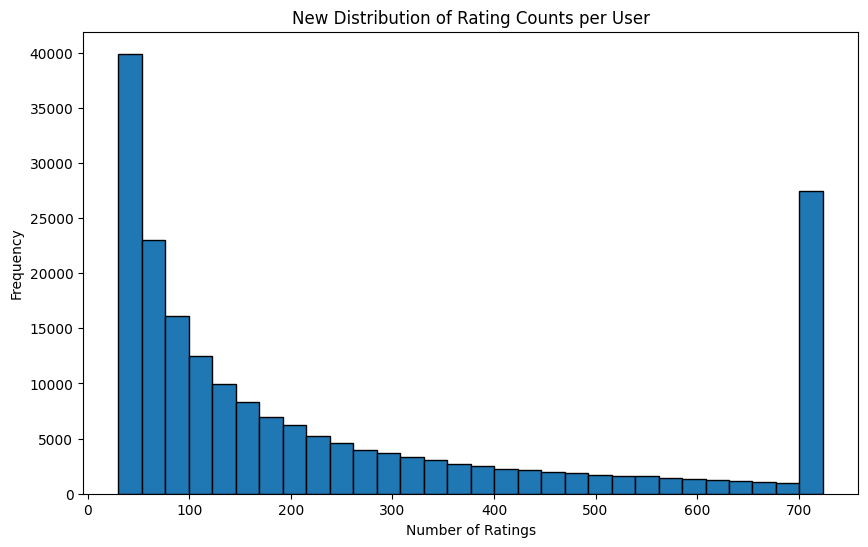

In [24]:
filtered_df_counts = filtered_df.groupBy("user_id").count()
filtered_df_counts = filtered_df_counts.withColumnRenamed("count", "ratings_count")
filtered_df_data = filtered_df_counts.toPandas()

plt.figure(figsize=(10, 6))
plt.hist(filtered_df_data['ratings_count'], bins=30, edgecolor='black')
plt.title('New Distribution of Rating Counts per User')
plt.xlabel('Number of Ratings')
plt.ylabel('Frequency')
plt.show()

Balance song distribution in same manner as user distribution.

In [25]:
song_ratings_count = df.groupBy("song_id").count()
song_ratings_count = song_ratings_count.withColumnRenamed("count", "ratings_count")
song_ratings_count.show()

+-------+-------------+
|song_id|ratings_count|
+-------+-------------+
|  34759|        11156|
|  43527|          126|
|  67376|         4366|
|  67753|          390|
|  80332|         2808|
| 113000|         4553|
| 117437|         1349|
| 133524|          157|
| 126373|          925|
|   1238|         4981|
|  47084|          881|
|   4935|         2878|
|  25591|          135|
|  29601|         2290|
|  38422|          136|
|  45341|          869|
|  47711|         1125|
|  82730|         1470|
|  93341|         2060|
| 128589|          211|
+-------+-------------+
only showing top 20 rows



In [26]:
min_max_values = song_ratings_count.select(min("ratings_count").alias("min_value"), max("ratings_count").alias("max_value")).first()

min_value = min_max_values["min_value"]
max_value = min_max_values["max_value"]

print("Minimum value:", min_value)
print("Maximum value:", max_value)

Minimum value: 74
Maximum value: 36810


Similar to ratings per users, the range between the minimum and maximum is extremely big. Distribution is extremely skewed, as shown in the histogram below. The are an extremely small amount of songs with more than 5000 ratings. The distribution needs to be adjusted to account for outliers.

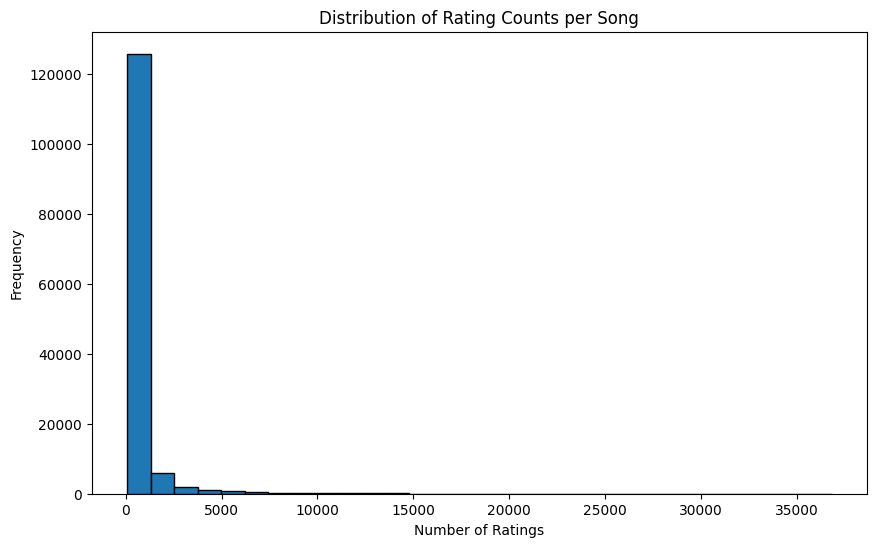

Total number of songs rated: 136736


In [27]:
data = song_ratings_count.toPandas()

plt.figure(figsize=(10, 6))
plt.hist(data['ratings_count'], bins=30, edgecolor='black')
plt.title('Distribution of Rating Counts per Song')
plt.xlabel('Number of Ratings')
plt.ylabel('Frequency')
plt.show()

total_songs = song_ratings_count.count()
print("Total number of songs rated:", total_songs)

In [28]:
quantiles = song_ratings_count.approxQuantile("ratings_count", [0.25, 0.75], 0.05)
Q1 = quantiles[0]
Q3 = quantiles[1]
IQR = Q3 - Q1

# lower_bound = Q1 - (1.5 * IQR)
upper_bound = Q3 + (1.5 * IQR)
print("Upper bound:", upper_bound)

# filtered_song_df = song_ratings_count.filter((col("ratings_count") >= lower_bound) & (col("ratings_count") <= upper_bound))
filtered_below_upper_bound = song_ratings_count.filter(col("ratings_count") < upper_bound)
ratings_below_upper_bound = df.join(filtered_below_upper_bound, on="song_id", how="inner")
songs_above_upper_bound = song_ratings_count.filter(col("ratings_count") > upper_bound)
ratings_above_upper_bound = df.join(songs_above_upper_bound, on="song_id", how="inner")

# Shuffle song ratings above the upper bound
ratings_with_random = ratings_above_upper_bound.withColumn("rand", rand())
window_spec = Window.partitionBy("song_id").orderBy("rand")

# Sample ratings above the upper bound to match the number of ratings at the upper bound
ratings_with_row_number = ratings_with_random.withColumn("row_number", row_number().over(window_spec))
resampled_ratings = ratings_with_row_number.filter(col("row_number") <= upper_bound).drop("rand", "row_number")

filtered_song_df = ratings_below_upper_bound.union(resampled_ratings)
print("Data count after downsampling song outliers:", filtered_song_df.count())

Upper bound: 794.5


Data count after downsampling song outliers: 46443280


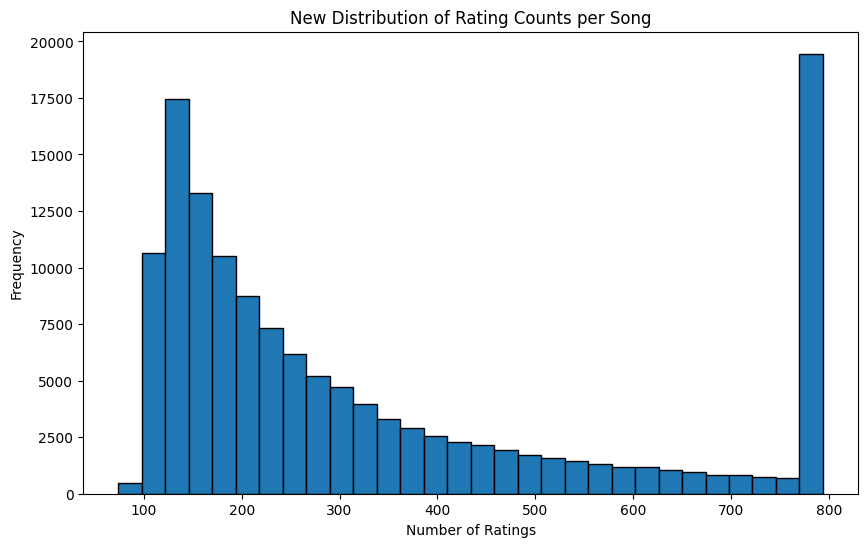

In [29]:
filtered_song_counts = filtered_song_df.groupBy("song_id").count()
filtered_song_counts = filtered_song_counts.withColumnRenamed("count", "ratings_count")
filtered_song_df_data = filtered_song_counts.toPandas()

plt.figure(figsize=(10, 6))
plt.hist(filtered_song_df_data['ratings_count'], bins=30, edgecolor='black')
plt.title('New Distribution of Rating Counts per Song')
plt.xlabel('Number of Ratings')
plt.ylabel('Frequency')
plt.show()

Similar to ratings per users, ratings count per songs are a lot less skewed with using IQR, upper bound, and lower bound to account for outliers.

In [30]:
filtered_user_song_df = filtered_df.join(filtered_song_df, on=["user_id", "song_id"], how="inner")
print("Dataset after joining downsampled user/song outliers:", filtered_user_song_df.count())

Dataset after joining downsampled user/song outliers: 26956383


In [31]:
# Create train test split such that there is still at least 10 random ratings per user in the test set
filtered_user_song_df = filtered_user_song_df.select("user_id", "song_id", filtered_df["rating"])

# Shuffle the data
shuffled_df = filtered_user_song_df.orderBy(rand())

# Assign row numbers within each user_id partition
window = Window.partitionBy("user_id").orderBy(rand())
df = shuffled_df.withColumn("row_number", row_number().over(window))

train_df = df.filter(col("row_number") > 10)
test_df = df.filter(col("row_number") <= 10)

train_df = train_df.drop("row_number")
test_df = test_df.drop("row_number")
train_df.show(20)
test_df.show(20)
print("Train data count:", train_df.count())
print("Test data count:", test_df.count())

+-------+-------+------+
|user_id|song_id|rating|
+-------+-------+------+
| 400001|   3723|     5|
| 400001| 105698|     5|
| 400001|  30670|     4|
| 400001|  82451|     5|
| 400003|  57127|     4|
| 400003|  78164|     5|
| 400003|  85415|     4|
| 400003| 116252|     5|
| 400003|  61078|     5|
| 400003| 113420|     4|
| 400003|  39507|     5|
| 400003|  49994|     4|
| 400003|  74990|     5|
| 400003| 110619|     4|
| 400003| 108105|     5|
| 400003|  88586|     4|
| 400003|  61463|     4|
| 400003|  73886|     4|
| 400003|  67102|     4|
| 400003| 133484|     4|
+-------+-------+------+
only showing top 20 rows



+-------+-------+------+
|user_id|song_id|rating|
+-------+-------+------+
| 400001|  94466|     4|
| 400001| 114356|     4|
| 400001| 110318|     4|
| 400001|  30670|     4|
| 400001| 117092|     5|
| 400001|  90136|     4|
| 400001|  83509|     4|
| 400001|   3723|     5|
| 400001|  66132|     5|
| 400001| 105698|     5|
| 400003|  11832|     5|
| 400003|  32908|     5|
| 400003|  81897|     5|
| 400003|  70537|     5|
| 400003| 131358|     3|
| 400003|  81473|     4|
| 400003|  39768|     5|
| 400003| 129582|     5|
| 400003|  81526|     4|
| 400003|  47025|     4|
+-------+-------+------+
only showing top 20 rows



Train data count: 24981650


Test data count: 1974733


Save the dataset locally to use to train model after loading it to HDFS.

In [32]:
# Make dirs if not exist
!mkdir -p $TRAIN_DIR
!mkdir -p $TEST_DIR

# Save Train to local
train_df = train_df.coalesce(1)
test_df = test_df.coalesce(1)
train_df.write.csv(f"file://{TRAIN_DIR}/temp", header=False, mode="overwrite", sep="\t")
test_df.write.csv(f"file://{TEST_DIR}/temp", header=False, mode="overwrite", sep="\t")

In [ ]:
# Move to single file
! rm -rf $TRAIN_DIR/train_0.txt
! mv $TRAIN_DIR/temp/part-00000* $TRAIN_DIR/train_0.txt
! rm -rf $TEST_DIR/test_0.txt
! mv $TEST_DIR/temp/part-00000* $TEST_DIR/test_0.txt

# Clean up
! rm -rf $TRAIN_DIR/temp
! rm -rf $TEST_DIR/temp